# Bayesian neural network

Bayesian neural network implementation using jax, flax, and blackjax

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree

try:
    import jaxopt
except ModuleNotFoundError:
    %pip install -qq jaxopt

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax


try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

In [4]:
latexify(width_scale_factor=2)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [5]:
class MLP1D(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.Dense(1)(x)
        return x


def bnn_log_joint(params, X, y, model):
    logits = model.apply(params, X).ravel()

    flatten_params, _ = ravel_pytree(params)
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = distrax.Bernoulli(logits=logits).log_prob(y).sum()

    log_joint = log_prior + log_likelihood
    return log_joint


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [6]:
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

In [7]:
noise = 0.2
num_samples = 50
num_warmup = 1000
num_steps = 500

model = MLP1D()
batch = jnp.ones((num_samples, 2))
params = model.init(key_init, batch)

X, y = make_moons(n_samples=num_samples, noise=noise, random_state=314)
potential = partial(bnn_log_joint, X=X, y=y, model=model)

In [8]:
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
states = inference_loop(key_samples, kernel, final_state, num_samples)

sampled_params = states.position

## Plotting decision surface

In [9]:
step = 0.2
vmin, vmax = X.min() - step, X.max() + step
X_grid = jnp.mgrid[vmin:vmax:100j, vmin:vmax:100j]

In [10]:
vapply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
vapply = jax.vmap(vapply, in_axes=(None, 1), out_axes=1)
vapply = jax.vmap(vapply, in_axes=(None, 2), out_axes=2)

logits_grid = vapply(sampled_params, X_grid)[..., -1]
p_grid = jax.nn.sigmoid(logits_grid)

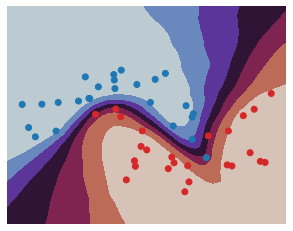

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
colors = ["tab:red" if yn == 1 else "tab:blue" for yn in y]
plt.scatter(*X.T, c=colors, zorder=1)
plt.contourf(*X_grid, p_grid.mean(axis=0), zorder=0, cmap="twilight")
plt.axis("off")
plt.title("Posterior mean")
savefig("bnn-grid")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
colors = ["tab:red" if yn == 1 else "tab:blue" for yn in y]
plt.scatter(*X.T, c=colors, zorder=1)
plt.contourf(*X_grid, p_grid.std(axis=0), zorder=0, cmap="viridis")
plt.axis("off")
plt.title("Posterior std")
plt.colorbar()
savefig("bnn-grid-std")